## MIMIC-IV-Note data exploration

See README for more info about the data.

Data documentation: https://mimic.mit.edu/docs/iv/modules/note/

In [18]:
import gzip
import shutil
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

In [2]:
data_dir = (Path.cwd() / ".." / ".." / "data").resolve()
assert data_dir.exists()
raw_data_dir = data_dir / "raw"
processed_data_dir = data_dir / "processed"

In [3]:
raw_mimic_dir = raw_data_dir / "mimic-iv-note" / "2.2" / "note"
assert raw_mimic_dir.exists()

In [4]:
gz_files = [p for p in raw_mimic_dir.iterdir() if p.name.endswith(".csv.gz")]
[p.name for p in gz_files]

['discharge.csv.gz',
 'discharge_detail.csv.gz',
 'radiology.csv.gz',
 'radiology_detail.csv.gz']

In [5]:
# uncompress the files
mimic_dir = processed_data_dir / "mimic-iv-note"
mimic_dir.mkdir(exist_ok=True)
for gz_filepath in gz_files:
    target_filepath = mimic_dir / gz_filepath.name[:-3]
    if not target_filepath.exists():
        with gzip.open(gz_filepath, "rb") as f_in:
            with open(target_filepath, "wb") as f_out:
                shutil.copyfileobj(f_in, f_out)

In [8]:
!du -h {mimic_dir}/*

4.1G	/panfs/jay/groups/25/lana/levon003/repos/scratchpad/finetune/data/processed/mimic-iv-note/discharge.csv
15M	/panfs/jay/groups/25/lana/levon003/repos/scratchpad/finetune/data/processed/mimic-iv-note/discharge_detail.csv
3.3G	/panfs/jay/groups/25/lana/levon003/repos/scratchpad/finetune/data/processed/mimic-iv-note/radiology.csv
358M	/panfs/jay/groups/25/lana/levon003/repos/scratchpad/finetune/data/processed/mimic-iv-note/radiology_detail.csv


In [9]:
!head -n 1 {mimic_dir}/*.csv

==> /panfs/jay/groups/25/lana/levon003/repos/scratchpad/finetune/data/processed/mimic-iv-note/discharge.csv <==
note_id,subject_id,hadm_id,note_type,note_seq,charttime,storetime,text

==> /panfs/jay/groups/25/lana/levon003/repos/scratchpad/finetune/data/processed/mimic-iv-note/discharge_detail.csv <==
note_id,subject_id,field_name,field_value,field_ordinal

==> /panfs/jay/groups/25/lana/levon003/repos/scratchpad/finetune/data/processed/mimic-iv-note/radiology.csv <==
note_id,subject_id,hadm_id,note_type,note_seq,charttime,storetime,text

==> /panfs/jay/groups/25/lana/levon003/repos/scratchpad/finetune/data/processed/mimic-iv-note/radiology_detail.csv <==
note_id,subject_id,field_name,field_value,field_ordinal


## Radiology

https://mimic.mit.edu/docs/iv/modules/note/radiology_detail/

In [10]:
rdf = pd.read_csv(mimic_dir / "radiology_detail.csv")
rdf.shape

(6046121, 5)

In [11]:
rdf["note_type"] = rdf.note_id.map(lambda note_id: note_id.split("-")[1])
rdf.note_type.value_counts()

RR    6020386
AR      25735
Name: note_type, dtype: int64

In [12]:
rdf.dtypes

note_id          object
subject_id        int64
field_name       object
field_value      object
field_ordinal     int64
note_type        object
dtype: object

In [14]:
unique_counts = rdf.nunique().rename("# unique")
na_counts = rdf.isna().sum(axis=0).rename("# NA")
cdf = pd.concat(
    [unique_counts, na_counts],
    axis=1,
)
cdf.sort_values(by="# unique", ascending=False)

,# unique,# NA
note_id,2327290,0
subject_id,238578,0
field_value,56423,0
field_ordinal,108,0
field_name,5,0
note_type,2,0


In [15]:
rdf.field_name.value_counts()

exam_code           2913024
exam_name           2913024
cpt_code             168603
parent_note_id        25735
addendum_note_id      25735
Name: field_name, dtype: int64

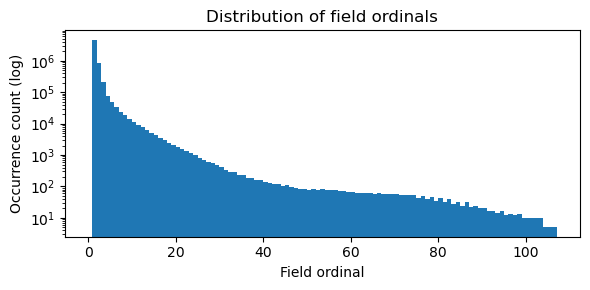

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))

ax.hist(rdf.field_ordinal, bins=np.arange(0, rdf.field_ordinal.max()), log=True)
ax.set_title("Distribution of field ordinals")
ax.set_ylabel("Occurrence count (log)")
ax.set_xlabel("Field ordinal")

fig.tight_layout()
plt.show()

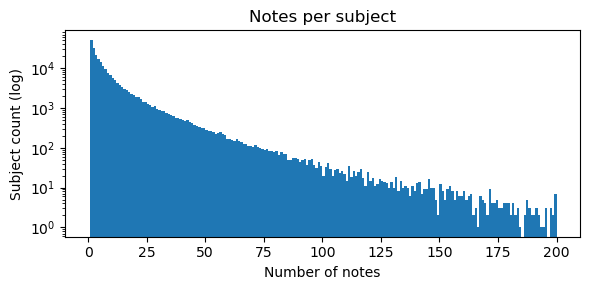

In [17]:
note_counts = rdf.groupby("subject_id").note_id.nunique().rename("note_counts")

fig, ax = plt.subplots(1, 1, figsize=(6, 3))

ax.hist(note_counts, bins=np.arange(0, 201), log=True)
ax.set_title("Notes per subject")
ax.set_ylabel("Subject count (log)")
ax.set_xlabel("Number of notes")

fig.tight_layout()
plt.show()

In [19]:
for note_id, group in tqdm(rdf.groupby("note_id")):
    assert group.field_name.nunique() == len(group)

  0%|                                                                                        | 1/2327290 [00:01<654:38:23,  1.01s/it]


AssertionError: 

In [20]:
group

,note_id,subject_id,field_name,field_value,field_ordinal,note_type
2,10000032-RR-15,10000032,exam_code,U314,1,RR
3,10000032-RR-15,10000032,exam_code,U644,3,RR
4,10000032-RR-15,10000032,exam_code,W82,2,RR
5,10000032-RR-15,10000032,exam_name,-59 DISTINCT PROCEDURAL SERVICE,2,RR
6,10000032-RR-15,10000032,exam_name,DUPLEX DOP ABD/PEL LIMITED,3,RR
7,10000032-RR-15,10000032,exam_name,LIVER OR GALLBLADDER US (SINGLE ORGAN),1,RR
